# Title: Reddit Sentiment and Stock Market Behavior: Exploring Correlation between Retail Investor Discourse and Market Trends





Group 6: Team Members


*   Sukriti Dhungel (sd3625@drexel.edu)
*   Steven Nguyen (sn924@drexel.edu)
*   Vincent So (vs634@drexel.edu)
*   Janhi Ong (jo659@drexel.edu)
*   Shailyshreyee Tagore (st3334@drexel.edu)





Installing necessary packages

In [ ]:
!pip3 install praw
!pip3 install requests
!pip3 install matplotlib
!pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 3.7 MB/s eta 0:00:00


Imports

In [ ]:
import pandas as pd
import praw
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Authentication to connect with the reddit API

In [ ]:
reddit = praw.Reddit(client_id='CCGhwZciAQHslVKerPhOoA',
client_secret='3u4H137B885jPCDvLNKdiANKBOeGVQ',
user_agent='Chrome')

##NEW CHANGES (DATA FROM 7/2024 - CURRENT)

In [ ]:
!pip install psaw

In [ ]:
import time
import logging
import warnings
from datetime import datetime, timezone
import pandas as pd

# Global configuration
START = datetime(2024, 7, 1, tzinfo=timezone.utc)
END   = datetime.now(timezone.utc)
SLEEP = 0.05
LOG_EVERY = 100

# Suppress library warnings during data pulling (FutureWarning, UserWarning, etc.)
warnings.filterwarnings("ignore")

# Reduce noisy library logs (keep only errors)
logging.basicConfig(level=logging.ERROR)
for _name in ("praw", "prawcore", "urllib3", "requests"):
    logging.getLogger(_name).setLevel(logging.ERROR)


# Helper functions
def _row_from_submission(s, label: str, subreddit_name: str):
    ts = getattr(s, "created_utc", None)
    if ts is None:
        return None
    return {
        "id": s.id,
        "title": s.title or "",
        "selftext": s.selftext or "",
        "score": s.score,
        "num_comments": s.num_comments,
        "created": pd.to_datetime(ts, unit="s", utc=True),
        "author": str(s.author) if s.author else None,
        "url": s.url,
        "subreddit": subreddit_name,
        "source": label,
    }


def _collect_windowed(gen, label: str, seen_ids: set, subreddit_name: str):
    rows, n = [], 0
    for s in gen:
        ts = getattr(s, "created_utc", None)
        if ts is None:
            continue

        dt = datetime.fromtimestamp(ts, tz=timezone.utc)
        if not (START <= dt <= END):
            continue

        if s.id in seen_ids:
            continue

        row = _row_from_submission(s, label, subreddit_name)
        if row:
            rows.append(row)
            seen_ids.add(s.id)
            n += 1
            if LOG_EVERY and (n % LOG_EVERY == 0):
                print(f"{label}: {n} collected…")

        time.sleep(SLEEP)

    return rows


def collect_subreddit(name: str, show_info: bool = True) -> pd.DataFrame:
    sub = reddit.subreddit(name)
    seen, rows = set(), []

    rows += _collect_windowed(sub.top(time_filter="year", limit=None), f"{name}:top_year", seen, name)

    rows += _collect_windowed(sub.top(time_filter="all", limit=None),  f"{name}:top_all",  seen, name)

    n = 0
    for s in sub.new(limit=None):
        ts = getattr(s, "created_utc", None)
        if ts is None:
            continue

        dt = datetime.fromtimestamp(ts, tz=timezone.utc)
        if dt < START:
            print(f"{name}: reached start date; stopping .new()")
            break

        if s.id in seen:
            continue

        row = _row_from_submission(s, f"{name}:new", name)
        if row:
            rows.append(row)
            seen.add(s.id)
            n += 1
            if LOG_EVERY and (n % LOG_EVERY == 0):
                print(f"{name}:new(): {n} collected…")

        time.sleep(SLEEP)

    # Build final per-sub DataFrame
    df = (
        pd.DataFrame(rows)
          .drop_duplicates(subset="id")
          .sort_values("created")
          .reset_index(drop=True)
    )

    # Ensure explicit subreddit label (redundant with row dict, but guarantees consistency)
    df["subreddit"] = name

    if show_info:
        print("\n" + "="*72)
        print(f"r/{name} — shape (best-effort): {df.shape}")
        df.info(memory_usage="deep")
        print("\nPosts by pass (source):")
        print(df["source"].value_counts(dropna=False))
        print("="*72 + "\n")

    return df


# Collect per-subreddit
df        = collect_subreddit("stocks",         show_info=True)
df_wsb    = collect_subreddit("wallstreetbets", show_info=True)
df_ss     = collect_subreddit("Superstonk",     show_info=True)
df_invest = collect_subreddit("investing",      show_info=True)

# Combine into a single DataFrame
df_combined_df = (
    pd.concat([df, df_wsb, df_ss, df_invest], ignore_index=True)
      .drop_duplicates(subset="id")
      .sort_values("created")
      .reset_index(drop=True)
)

print(f"Combined dataset now has {len(df_combined_df)} posts.")

stocks:top_year: 100 collected…
stocks:top_year: 200 collected…
stocks:top_year: 300 collected…
stocks:top_year: 400 collected…
stocks:top_year: 500 collected…
stocks:top_year: 600 collected…
stocks:top_year: 700 collected…
stocks:top_all: 100 collected…
stocks:top_all: 200 collected…
stocks:new(): 100 collected…
stocks:new(): 200 collected…
stocks:new(): 300 collected…
stocks:new(): 400 collected…
stocks:new(): 500 collected…
stocks:new(): 600 collected…
stocks:new(): 700 collected…
stocks:new(): 800 collected…

r/stocks — shape (best-effort): (1784, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1784 entries, 0 to 1783
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   id            1784 non-null   object             
 1   title         1784 non-null   object             
 2   selftext      1784 non-null   object             
 3   score         1784 non-null   int64              
 

In [ ]:
df_combined_df.head()

,id,title,selftext,score,num_comments,created,author,url,subreddit,source
0,1dsl6ap,RC Tweet,,7629,280,2024-07-01 05:23:01+00:00,Hoppel21_6,https://i.redd.it/kdub0qs7eu9d1.jpeg,Superstonk,Superstonk:top_year
1,1dspjmh,What makes YOU decide to invest on a stock?,"Whenever i'm looking on a potential buy, i sta...",204,270,2024-07-01 10:19:29+00:00,tempo121212123,https://www.reddit.com/r/stocks/comments/1dspj...,stocks,stocks:top_year
2,1dsprnu,DFV files a 6.6% stake in CHWY,"edit : he owns 6.6% of the float, not the enti...",8449,1232,2024-07-01 10:33:53+00:00,someroastedbeef,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year
3,1dsprud,RK has filed a SEC 13-G for CHWY - he now owns...,,5128,416,2024-07-01 10:34:16+00:00,Lorddale04,https://investor.chewy.com/financials/sec-fili...,Superstonk,Superstonk:top_year
4,1dsqk9h,DFV DIDNT LEAVE,You think he would come back after three years...,4364,330,2024-07-01 11:22:37+00:00,CheekyTrey,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year


preprocessing

In [ ]:
df_combined_df.isnull().sum()

,0
id,0
title,0
selftext,0
score,0
num_comments,0
created,0
author,124
url,0
subreddit,0
source,0


clean text

In [ ]:
import re
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"&amp;", "&", text)
    text = re.sub(r"[^a-zA-Z0-9$.,!?'\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()

df_combined_df['clean_text'] = df_combined_df['selftext'].apply(clean_text)

df_combined_df[['selftext', 'clean_text']].head()

,selftext,clean_text
0,,
1,"Whenever i'm looking on a potential buy, i sta...","whenever i'm looking on a potential buy, i sta..."
2,"edit : he owns 6.6% of the float, not the enti...","edit he owns 6.6 of the float, not the entire ..."
3,,
4,You think he would come back after three years...,you think he would come back after three years...


In [ ]:
df_combined_df.head(5)

,id,title,selftext,score,num_comments,created,author,url,subreddit,source,clean_text
0,1dsl6ap,RC Tweet,,7629,280,2024-07-01 05:23:01+00:00,Hoppel21_6,https://i.redd.it/kdub0qs7eu9d1.jpeg,Superstonk,Superstonk:top_year,
1,1dspjmh,What makes YOU decide to invest on a stock?,"Whenever i'm looking on a potential buy, i sta...",204,270,2024-07-01 10:19:29+00:00,tempo121212123,https://www.reddit.com/r/stocks/comments/1dspj...,stocks,stocks:top_year,"whenever i'm looking on a potential buy, i sta..."
2,1dsprnu,DFV files a 6.6% stake in CHWY,"edit : he owns 6.6% of the float, not the enti...",8449,1232,2024-07-01 10:33:53+00:00,someroastedbeef,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,"edit he owns 6.6 of the float, not the entire ..."
3,1dsprud,RK has filed a SEC 13-G for CHWY - he now owns...,,5128,416,2024-07-01 10:34:16+00:00,Lorddale04,https://investor.chewy.com/financials/sec-fili...,Superstonk,Superstonk:top_year,
4,1dsqk9h,DFV DIDNT LEAVE,You think he would come back after three years...,4364,330,2024-07-01 11:22:37+00:00,CheekyTrey,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,you think he would come back after three years...


In [ ]:
print(df_combined_df.shape)

(6503, 11)


remove stopwords

In [ ]:
# install stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

df_combined_df['clean_text'] = df_combined_df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

In [ ]:
df_combined_df['clean_text'] = df_combined_df['clean_text'].apply(lambda x: re.sub(r"[^\w\s$]", "", x))

In [ ]:
df_combined_df.head(5)

,id,title,selftext,score,num_comments,created,author,url,subreddit,source,clean_text
0,1dsl6ap,RC Tweet,,7629,280,2024-07-01 05:23:01+00:00,Hoppel21_6,https://i.redd.it/kdub0qs7eu9d1.jpeg,Superstonk,Superstonk:top_year,
1,1dspjmh,What makes YOU decide to invest on a stock?,"Whenever i'm looking on a potential buy, i sta...",204,270,2024-07-01 10:19:29+00:00,tempo121212123,https://www.reddit.com/r/stocks/comments/1dspj...,stocks,stocks:top_year,whenever looking potential buy start looking h...
2,1dsprnu,DFV files a 6.6% stake in CHWY,"edit : he owns 6.6% of the float, not the enti...",8449,1232,2024-07-01 10:33:53+00:00,someroastedbeef,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,edit owns 66 float entire company keith gill t...
3,1dsprud,RK has filed a SEC 13-G for CHWY - he now owns...,,5128,416,2024-07-01 10:34:16+00:00,Lorddale04,https://investor.chewy.com/financials/sec-fili...,Superstonk,Superstonk:top_year,
4,1dsqk9h,DFV DIDNT LEAVE,You think he would come back after three years...,4364,330,2024-07-01 11:22:37+00:00,CheekyTrey,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,think would come back three years livestream l...


pull tickers

In [ ]:
df_combined_df['tickers'] = df_combined_df['clean_text'].apply(lambda x: re.findall(r'\$[A-Za-z]{1,5}', x.upper()))

In [ ]:
unique_tickers = set(ticker for sublist in df_combined_df['tickers'] for ticker in sublist)
unique_tickers

{'$AAPL',
 '$ABAT',
 '$ACHR',
 '$AEO',
 '$AIFU',
 '$AIFUS',
 '$ALGN',
 '$AMD',
 '$AMZN',
 '$ANF',
 '$APLD',
 '$APO',
 '$APP',
 '$ARES',
 '$ARKW',
 '$ARM',
 '$ASML',
 '$ASPI',
 '$ASTS',
 '$BABA',
 '$BE',
 '$BGM',
 '$BILLI',
 '$BITF',
 '$BITX',
 '$BLMN',
 '$BLSH',
 '$BMBL',
 '$BMNR',
 '$BRK',
 '$BROS',
 '$BTBT',
 '$BTC',
 '$BULL',
 '$CAKE',
 '$CAVA',
 '$CEG',
 '$CELH',
 '$CLOV',
 '$CMG',
 '$COIN',
 '$COST',
 '$CRSR',
 '$CRWD',
 '$CRWV',
 '$CVX',
 '$DHI',
 '$ENSG',
 '$EZPW',
 '$EZU',
 '$FEZ',
 '$FIG',
 '$FLR',
 '$FSLR',
 '$FXAIX',
 '$FXI',
 '$GAINL',
 '$GAMB',
 '$GILD',
 '$GME',
 '$GMES',
 '$GNRC',
 '$GOOG',
 '$GOOGL',
 '$GRAB',
 '$HE',
 '$HIMS',
 '$HOOD',
 '$HR',
 '$HUBB',
 '$I',
 '$IAN',
 '$INOD',
 '$INTC',
 '$IONQ',
 '$IQ',
 '$IRA',
 '$JNJ',
 '$JOBY',
 '$KIEV',
 '$KO',
 '$KWEB',
 '$LEN',
 '$LEU',
 '$LLY',
 '$LMND',
 '$LMT',
 '$LTHM',
 '$LULU',
 '$MDB',
 '$MELI',
 '$MELIS',
 '$MER',
 '$META',
 '$MONTH',
 '$MP',
 '$MRNA',
 '$MRVL',
 '$MSFT',
 '$MSTR',
 '$MU',
 '$NAN',
 '$NBISS',
 '$NEGG'

In [ ]:
df_combined_df.head(5)

,id,title,selftext,score,num_comments,created,author,url,subreddit,source,clean_text,tickers
0,1dsl6ap,RC Tweet,,7629,280,2024-07-01 05:23:01+00:00,Hoppel21_6,https://i.redd.it/kdub0qs7eu9d1.jpeg,Superstonk,Superstonk:top_year,,[]
1,1dspjmh,What makes YOU decide to invest on a stock?,"Whenever i'm looking on a potential buy, i sta...",204,270,2024-07-01 10:19:29+00:00,tempo121212123,https://www.reddit.com/r/stocks/comments/1dspj...,stocks,stocks:top_year,whenever looking potential buy start looking h...,[]
2,1dsprnu,DFV files a 6.6% stake in CHWY,"edit : he owns 6.6% of the float, not the enti...",8449,1232,2024-07-01 10:33:53+00:00,someroastedbeef,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,edit owns 66 float entire company keith gill t...,[]
3,1dsprud,RK has filed a SEC 13-G for CHWY - he now owns...,,5128,416,2024-07-01 10:34:16+00:00,Lorddale04,https://investor.chewy.com/financials/sec-fili...,Superstonk,Superstonk:top_year,,[]
4,1dsqk9h,DFV DIDNT LEAVE,You think he would come back after three years...,4364,330,2024-07-01 11:22:37+00:00,CheekyTrey,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,think would come back three years livestream l...,[]


### VALIDATE TICKERS FROM YAHOO FINANCE

In [ ]:
# install yfinance
!pip install yfinance

In [ ]:
# Unique raw tokens from the column (still include leading $)
unique_tokens = {tok for lst in df_combined_df['tickers'] for tok in lst}

# Normalize: strip '$', uppercase, keep 1–5 letters
import re
unique_tickers = sorted({
    re.sub(r'^\$', '', tok).upper()
    for tok in unique_tokens
    if re.fullmatch(r'\$?[A-Z]{1,5}', tok or '')
})
print(f"Found {len(unique_tickers)} unique ticker-like strings")


Found 187 unique ticker-like strings


In [ ]:
import yfinance as yf
from functools import lru_cache

@lru_cache(maxsize=None)
def is_valid_ticker(ticker: str) -> bool:
    try:
        # If it has any price history, treat as valid
        hist = yf.Ticker(ticker).history(period="1d")
        return not hist.empty
    except Exception:
        return False

valid_tickers = [t for t in unique_tickers if is_valid_ticker(t)]
invalid_tickers = sorted(set(unique_tickers) - set(valid_tickers))

print("Valid Tickers:", valid_tickers)
print("Invalid Tickers:", invalid_tickers)

ERROR:yfinance:HTTP Error 404: 
ERROR:yfinance:$AIFUS: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:HTTP Error 404: 
ERROR:yfinance:$BILLI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$BRK: possibly delisted; no price data found  (period=1d)
ERROR:yfinance:$GMES: possibly delisted; no price data found  (period=1d)
ERROR:yfinance:$I: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$IAN: possibly delisted; no price data found  (period=1d)
ERROR:yfinance:$IRA: possibly delisted; no price data found  (period=1d)
ERROR:yfinance:$KIEV: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$LTHM: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delis

Valid Tickers: ['AAPL', 'ABAT', 'ACHR', 'AEO', 'AIFU', 'ALGN', 'AMD', 'AMZN', 'ANF', 'APLD', 'APO', 'APP', 'ARES', 'ARKW', 'ARM', 'ASML', 'ASPI', 'ASTS', 'BABA', 'BE', 'BGM', 'BITF', 'BITX', 'BLMN', 'BLSH', 'BMBL', 'BMNR', 'BROS', 'BTBT', 'BTC', 'BULL', 'CAKE', 'CAVA', 'CEG', 'CELH', 'CLOV', 'CMG', 'COIN', 'COST', 'CRSR', 'CRWD', 'CRWV', 'CVX', 'DHI', 'ENSG', 'EZPW', 'EZU', 'FEZ', 'FIG', 'FLR', 'FSLR', 'FXAIX', 'FXI', 'GAINL', 'GAMB', 'GILD', 'GME', 'GNRC', 'GOOG', 'GOOGL', 'GRAB', 'HE', 'HIMS', 'HOOD', 'HR', 'HUBB', 'INOD', 'INTC', 'IONQ', 'IQ', 'JNJ', 'JOBY', 'KO', 'KWEB', 'LEN', 'LEU', 'LLY', 'LMND', 'LMT', 'LULU', 'MDB', 'MELI', 'MER', 'META', 'MP', 'MRNA', 'MRVL', 'MSFT', 'MSTR', 'MU', 'NAN', 'NEGG', 'NFLX', 'NKE', 'NNE', 'NU', 'NUE', 'NUVB', 'NVDA', 'NVS', 'O', 'OKLO', 'ONDS', 'ONON', 'OPEN', 'ORCL', 'ORR', 'OXY', 'PACS', 'PANW', 'PARA', 'PATH', 'PFE', 'PG', 'PL', 'PLMR', 'PLTR', 'PONY', 'PTLO', 'PYPL', 'QCOM', 'QQQ', 'RDDT', 'RDW', 'RKLB', 'ROOT', 'ROPE', 'RUN', 'S', 'SCHD', 'SG

In [ ]:
valid_set = set(valid_tickers)

# Normalize each row’s list then keep only valid
df_combined_df['tickers'] = df_combined_df['tickers'].apply(
    lambda lst: [
        re.sub(r'^\$', '', t).upper()
        for t in lst
        if re.sub(r'^\$', '', t).upper() in valid_set
    ]
)

In [ ]:
# get unique values of tickers
unique_tickers = set(ticker for sublist in df_combined_df['tickers'] for ticker in sublist)
unique_tickers

# number of unique values
len(unique_tickers)

169

In [ ]:
def find_plain_tickers(text):
    words = re.findall(r'\b[A-Za-z]{1,5}\b', str(text).upper())  # 1–5 letters, word boundaries
    return [w for w in words if w in valid_set]

df_combined_df['plain_tickers'] = df_combined_df['clean_text'].apply(find_plain_tickers)

df_combined_df['dollar_tickers'] = df_combined_df['clean_text'].apply(
    lambda x: [t.replace('$', '') for t in re.findall(r'\$[A-Za-z]{1,5}', str(x).upper())]
)

df_combined_df['all_tickers'] = df_combined_df.apply(
    lambda row: list(set(row['dollar_tickers'] + row['plain_tickers'])),
    axis=1
)

In [ ]:
df_combined_df.head(5)

,id,title,selftext,score,num_comments,created,author,url,subreddit,source,clean_text,tickers,plain_tickers,dollar_tickers,all_tickers
0,1dsl6ap,RC Tweet,,7629,280,2024-07-01 05:23:01+00:00,Hoppel21_6,https://i.redd.it/kdub0qs7eu9d1.jpeg,Superstonk,Superstonk:top_year,,[],[],[],[]
1,1dspjmh,What makes YOU decide to invest on a stock?,"Whenever i'm looking on a potential buy, i sta...",204,270,2024-07-01 10:19:29+00:00,tempo121212123,https://www.reddit.com/r/stocks/comments/1dspj...,stocks,stocks:top_year,whenever looking potential buy start looking h...,[],[],[],[]
2,1dsprnu,DFV files a 6.6% stake in CHWY,"edit : he owns 6.6% of the float, not the enti...",8449,1232,2024-07-01 10:33:53+00:00,someroastedbeef,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,edit owns 66 float entire company keith gill t...,[],[COST],[],[COST]
3,1dsprud,RK has filed a SEC 13-G for CHWY - he now owns...,,5128,416,2024-07-01 10:34:16+00:00,Lorddale04,https://investor.chewy.com/financials/sec-fili...,Superstonk,Superstonk:top_year,,[],[],[],[]
4,1dsqk9h,DFV DIDNT LEAVE,You think he would come back after three years...,4364,330,2024-07-01 11:22:37+00:00,CheekyTrey,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,think would come back three years livestream l...,[],[GME],[],[GME]


feature engineer tickers

In [ ]:
# look at the last 4 columns
# expan the text column width to see all content
pd.set_option('display.max_colwidth', None)
df_combined_df[['clean_text', 'tickers', 'plain_tickers', 'dollar_tickers', 'all_tickers']].head(50)

,clean_text,tickers,plain_tickers,dollar_tickers,all_tickers
0,,[],[],[],[]
1,whenever looking potential buy start looking history present take guess future news others opinions time buy keep saying wait go lower want catch falling knife etc etc going high bet probably going go soon invest decide stocks go for when,[],[],[],[]
2,edit owns 66 float entire company keith gill today morning disclosed 9001000 share position chwy disclosed cost basis is buys sells additional shares would trigger form 4 disclosure peoples thoughts this chwy value play also first official filing sec questioning authenticity cat question form 13s customized questions like that hes obviously memeing also sec website,[],[COST],[],[COST]
3,,[],[],[],[]
4,think would come back three years livestream long term thesis stock hasnt left past three years jump abandon ship wrong still part plan think sold calls bought shares gme sell exact shares next weeks no dfv built war chest potential plans sell shares buy chewy,[],[GME],[],[GME]
5,boeing said monday buy back struggling fuselage maker spirit aerosystems allstock deal planemaker said improve safety quality control said agreed pay $3725 share boeing stock spirit giving aerospace company equity value $47 billion including spirits debt deal transaction value $83 billion boeing said spirits shares closed friday $3287 share giving market capitalization $38 billion boeing march disclosed talks acquire wichita kansasbased company weeks fuselage panel blew midair nearly new boeing 737 max 9 alaska airlines flight sparking fresh crisis boeing spirit makes fuselages 737 parts including sections boeings 787 dreamliners 2005 boeing spun operations kansas oklahoma became presentday spirit aerosystems boeing accounted 70 spirits revenue last year roughly quarter came making parts boeings main rival airbus according securities filing ceo dave calhoun said step end year monday said bringing spirit inhouse fully align companies production systems workforces among many actions taking company one significant demonstrating unwavering commitment strengthen quality make certain boeing company world needs be dave calhoun said message employees said expects deal close mid2025 subject approval regulators spirit shareholders sale spirits operators dedicated airbus planes spirits ceo pat shanahan considered possible replacement calhoun airbus meanwhile said monday reached agreement spirit european aircraft manufacturer compensated $559 million spirit acquire manufacturing lines dedicated airbus planes include operations belfast northern ireland wings midfuselage a220 produced a220 pylons wichita kansas a350 fuselage sections north carolina mounting pressure preliminary report national transportation safety board jan 5 accident said appeared bolts hold door plug place werent attached max 9 left boeings factory handed alaska airlines months accident serious host production problems boeing planes also included spiritmade fuselages misdrilled holes misconnected fuselage panels crisis stemming doorplug blowout alaska flight slowed boeings deliveries new planes airlines driven financial hits spirit boeing boeings cfo may said company would burn rather generate cash yearabout $8 billion first half 2024 boeings shares 30 year one way boeing tried improve quality accept fuselages without defects repairs additional manufacturing steps wont made sequence reducing changes errors federal aviation administration said wont let boeing expand production satisfied production lines calhoun skewered lawmakers june senate hearing companys safety record senators lamented lack improvement wake two deadly max crashes source,[],[BE],[],[BE]
6,understand sp500 safe however see google amazon apple example going fashion since essential profitable invest solely top companies short term thing thanks advance,[],[],[],[]
7,really strange months seems like bad economic news example unemployment worse expected manufacturing worse expected stock market goes up one exce

In [ ]:
# delete tickers', 'plain_tickers', 'dollar_tickers
df_combined_df = df_combined_df.drop(columns=['tickers', 'plain_tickers', 'dollar_tickers'])

In [ ]:
# undo display max
pd.reset_option('display.max_colwidth')
df_combined_df.head()

,id,title,selftext,score,num_comments,created,author,url,subreddit,source,clean_text,all_tickers
0,1dsl6ap,RC Tweet,,7629,280,2024-07-01 05:23:01+00:00,Hoppel21_6,https://i.redd.it/kdub0qs7eu9d1.jpeg,Superstonk,Superstonk:top_year,,[]
1,1dspjmh,What makes YOU decide to invest on a stock?,"Whenever i'm looking on a potential buy, i sta...",204,270,2024-07-01 10:19:29+00:00,tempo121212123,https://www.reddit.com/r/stocks/comments/1dspj...,stocks,stocks:top_year,whenever looking potential buy start looking h...,[]
2,1dsprnu,DFV files a 6.6% stake in CHWY,"edit : he owns 6.6% of the float, not the enti...",8449,1232,2024-07-01 10:33:53+00:00,someroastedbeef,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,edit owns 66 float entire company keith gill t...,[COST]
3,1dsprud,RK has filed a SEC 13-G for CHWY - he now owns...,,5128,416,2024-07-01 10:34:16+00:00,Lorddale04,https://investor.chewy.com/financials/sec-fili...,Superstonk,Superstonk:top_year,,[]
4,1dsqk9h,DFV DIDNT LEAVE,You think he would come back after three years...,4364,330,2024-07-01 11:22:37+00:00,CheekyTrey,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,think would come back three years livestream l...,[GME]


In [ ]:
print(df_combined_df.shape)

(6503, 12)


dates and tickers from yahoo finance to join with main df

In [ ]:
# pip install yfinance pandas numpy

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt


start = "2024-07-01"
end = dt.date.today().strftime("%Y-%m-%d")
bench = "SPY"

tickers = [
    'AAPL','ABAT','ACHR','ADBE','AEO','ALGN','AMD','AMZN','ANF','APH','APLD','APLS','ASML','AVGO','BA','BKNG',
    'BLMN','BMNR','BROS','BTBT','BULL','CAKE','CAVA','CHPT','CLOV','CMG','COIN','CURI','CVX','CZR','DIS','DJT',
    'DNUT','EL','ENPH','ENVX','EZPW','EZU','F','FBL','FEZ','FIG','FLR','FLY','FOUR','FSLR','FUBO','FXI','GDX',
    'GILD','GLXY','GM','GME','GOOGL','GRAB','HIMS','HOOD','IDRV','INOD','INTC','IREN','JNJ','JPM','KO','KSS',
    'KWEB','LCID','LIT','LLY','LRN','M','MAGS','META','MP','MSFT','MU','NAN','NBIS','NET','NKE','NVDA','NVS',
    'NVT','OPEN','PG','PLMR','PLTR','POET','PTLO','PZZA','QCOM','QQQ','RDDT','RDW','RIVN','RKLB','RNG','ROKU',
    'SCHD','SMCI','SNAP','SOFI','SPOT','SPY','SRPT','TIP','TLRY','TLT','TMC','TSLA','TSM','UBER','UNH','USAR',
    'UUUU','V','VFC','VOYG','VRT','WB','WEN','WING','WYFI','XLE','XOM','XRT'
]

def get_adj_close(tickers_list, start_date, end_date): # Downloads Adjusted Close for tickers; drop ones with no data
    # ensure benchmark is present for relative returns
    if bench not in tickers_list:
        tickers_list = tickers_list + [bench]

    raw = yf.download(
        tickers_list, start=start_date, end=end_date,
        group_by="column", auto_adjust=False, progress=False, threads=True, interval="1d"
    )

    # normalize to a plain DataFrame of adjusted closes
    if isinstance(raw.columns, pd.MultiIndex):
        adj = raw["Adj Close"].copy()
    else:
        adj = raw.to_frame(name=tickers_list[0])

    # insert any missing columns (as NaN), keep original order
    for t in tickers_list:
        if t not in adj.columns:
            adj[t] = np.nan
    adj = adj.reindex(columns=tickers_list)

    # mark and drop tickers with no data in the window
    failed = [t for t in tickers_list if adj[t].isna().all()]
    adj = adj.drop(columns=failed, errors="ignore")

    # align to business days and forward-fill so joins are easy
    adj = adj.asfreq("B").ffill()
    adj.index.name = "date"
    return adj, failed

# prices
adj, failed = get_adj_close(tickers, start, end)
print(f"downloaded {adj.shape[1]} tickers; failed: {failed}")

# simple features
ret = adj.pct_change()
cum = (1 + ret).cumprod()
if bench in ret.columns:
    exret = ret.sub(ret[bench], axis=0)
else:
    exret = pd.DataFrame(index=ret.index, columns=ret.columns)

# period summary (how each name did over the whole window)
period_return = (1 + ret).prod() - 1
summary = pd.DataFrame({"period_return": period_return})
if bench in summary.index:
    summary["outperformance_vs_bench"] = summary["period_return"] - summary.loc[bench, "period_return"]
summary = summary.sort_values("period_return", ascending=False)

# tidy table for joining to Reddit (date × ticker)
combined = pd.concat(
    {"adj_close": adj, "ret_1d": ret, "cum_growth": cum, "exret_vs_bench": exret},
    axis=1
)
combined.columns = combined.columns.set_names(["feature", "ticker"])
long = combined.stack("ticker").reset_index().sort_values(["ticker", "date"])
long["date"] = pd.to_datetime(long["date"]).dt.tz_localize(None)

# save
adj.to_csv(f"adj_close_{start}_to_{end}.csv")
long.to_csv(f"features_long_{start}_to_{end}.csv", index=False)
summary.to_csv(f"summary_{start}_to_{end}.csv")

print("saved: adj_close_*.csv, features_long_*.csv, summary_*.csv")

downloaded 126 tickers; failed: []
saved: adj_close_*.csv, features_long_*.csv, summary_*.csv


In [ ]:
adj.head(5)

Ticker,AAPL,ABAT,ACHR,ADBE,AEO,ALGN,AMD,AMZN,ANF,APH,...,VFC,VOYG,VRT,WB,WEN,WING,WYFI,XLE,XOM,XRT
date,,,,,,,,,,,,,,,,,,,,,
2024-07-01,215.496490,1.160,3.42,560.010010,18.567329,238.639999,157.690002,197.199997,184.589996,66.904388,...,12.573030,NaN,86.542595,6.940446,15.516376,422.713715,NaN,88.288094,110.062325,72.585381
2024-07-02,218.996109,1.100,3.72,567.710022,18.529047,239.740005,164.309998,200.000000,183.360001,66.944038,...,12.563238,NaN,87.880768,7.227019,15.393603,418.871216,NaN,88.220329,109.315552,72.674149
2024-07-03,220.268707,1.035,4.21,570.150024,18.471621,243.369995,163.899994,197.589996,179.750000,67.171936,...,12.729704,NaN,93.293427,7.450904,15.374716,416.591614,NaN,88.607567,109.870842,72.476898
2024-07-04,220.268707,1.035,4.21,570.150024,18.471621,243.369995,163.899994,197.589996,179.750000,67.171936,...,12.729704,NaN,93.293427,7.450904,15.374716,416.591614,NaN,88.607567,109.870842,72.476898
2024-07-05,225.031006,1.010,4.40,578.340027,18.385483,243.600006,171.899994,200.000000,171.539993,67.389938,...,12.680744,NaN,91.655655,7.361351,15.355829,416.820526,NaN,87.223221,108.540062,72.437447


merge the csv and the main df

In [ ]:
# Preparing Reddit posts
df_joined = df_combined_df.copy()

# Unifying to a single date field
df_joined["created"] = pd.to_datetime(df_joined["created"])
df_joined["date"] = pd.to_datetime(df_joined["created"]).dt.tz_localize(None)

# Exploding to one ticker per row → 'ticker'
df_joined = df_joined.explode("all_tickers").rename(columns={"all_tickers": "ticker"})

# Normalizing tickers (uppercase, stripping)
df_joined["ticker"] = (
    df_joined["ticker"]
    .astype("string")
    .str.upper()
    .str.replace(r"[^A-Z\.]", "", regex=True)
    .str.strip()
)

# Dropping rows with no ticker after cleaning
df_joined = df_joined[df_joined["ticker"].notna() & (df_joined["ticker"] != "")].copy()

# Dropping duplicate created column
df_joined = df_joined.drop(columns=["created"], errors="ignore")

# Preparing finance features
long["date"] = pd.to_datetime(long["date"])
long["ticker"] = long["ticker"].str.upper()

valid_tickers = set(long["ticker"].unique().tolist())
df_joined = df_joined[df_joined["ticker"].isin(valid_tickers)].copy()

# Ensuring Reddit side is datetime too
df_joined["date"] = pd.to_datetime(df_joined["date"])

# Using DatetimeIndex (safe, no mixed types)
trading_days = pd.DatetimeIndex(sorted(long["date"].unique()))

def prev_trading_day(d):
    d = pd.to_datetime(d).normalize().tz_localize(None)
    idx = trading_days.searchsorted(d, side="right") - 1
    return trading_days[idx] if idx >= 0 else None

# Mapping to previous trading day
df_joined["trade_date"] = df_joined["date"].apply(prev_trading_day)
df_joined = df_joined[df_joined["trade_date"].notna()].copy()

# Merging on (trade_date, ticker)
merged = pd.merge(
    df_joined,
    long.rename(columns={"date": "trade_date"}),
    how="left",
    on=["trade_date", "ticker"]
)

# Keeping both: Reddit timestamp (date) and trading alignment (trade_date)
# If you really want to overwrite, uncomment the next line:
# merged = merged.rename(columns={"trade_date": "date"})

# Keeping tidy column order
keep_cols = [
    "id","title","selftext","score","num_comments","author","url","subreddit",
    "source","text","hour","day","clean_text","ticker","date","trade_date",
    "adj_close","ret_1d","cum_growth","exret_vs_bench"
]
merged = merged[[c for c in keep_cols if c in merged.columns]].copy()

# Running quick diagnostics
n_total = len(df_combined_df)
n_after_explode = len(df_joined)
n_merged = merged[["adj_close","ret_1d","cum_growth","exret_vs_bench"]].notna().all(axis=1).sum()

print({
    "rows_in_original_posts_df": n_total,
    "rows_after_explode_and_clean": n_after_explode,
    "rows_with_all_market_features_filled": n_merged,
    "missing_after_merge_per_col": merged[["ticker","adj_close","ret_1d","cum_growth","exret_vs_bench"]].isna().sum().to_dict(),
})

{'rows_in_original_posts_df': 6503, 'rows_after_explode_and_clean': 2031, 'rows_with_all_market_features_filled': np.int64(2022), 'missing_after_merge_per_col': {'ticker': 0, 'adj_close': 6, 'ret_1d': 9, 'cum_growth': 9, 'exret_vs_bench': 9}}


In [ ]:
merged.head()

,id,title,selftext,score,num_comments,author,url,subreddit,source,clean_text,ticker,date,trade_date,adj_close,ret_1d,cum_growth,exret_vs_bench
0,1dsqk9h,DFV DIDNT LEAVE,You think he would come back after three years...,4364,330,CheekyTrey,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,think would come back three years livestream l...,GME,2024-07-01 11:22:37,2024-07-01,23.330000,NaN,NaN,NaN
1,1dtojws,Isn't it obvious at this point? DFV's next 13G...,"With the dog play shuffling everybody, and rev...",4534,399,batmanbury,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,dog play shuffling everybody revealing us much...,GME,2024-07-02 15:26:14,2024-07-02,23.980000,0.027861,1.027861,0.021131
2,1dtrpmu,Could the AI bubble end up looking like MSFT a...,MSFT hit a high in 1999 then came down by half...,176,217,quarantine000,https://www.reddit.com/r/investing/comments/1d...,investing,investing:top_year,msft hit high 1999 came half stayed 15 years t...,NVDA,2024-07-02 17:35:59,2024-07-02,122.631256,-0.013114,0.986886,-0.019843
3,1dtrpmu,Could the AI bubble end up looking like MSFT a...,MSFT hit a high in 1999 then came down by half...,176,217,quarantine000,https://www.reddit.com/r/investing/comments/1d...,investing,investing:top_year,msft hit high 1999 came half stayed 15 years t...,MSFT,2024-07-02 17:35:59,2024-07-02,455.037445,0.005583,1.005583,-0.001147
4,1dtv3zj,The GME - KOSS Connection: The spark to ignite...,"First off, I want to say that nothing in this ...",7222,1418,Otherwise-Category42,https://www.reddit.com/r/Superstonk/comments/1...,Superstonk,Superstonk:top_year,first off want say nothing post financial advi...,GME,2024-07-02 19:57:38,2024-07-02,23.980000,0.027861,1.027861,0.021131


In [ ]:
print(merged.shape)

(2031, 17)


In [ ]:
from google.colab import files
merged.to_csv('merged.csv', index=False)

files.download("merged.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

eda

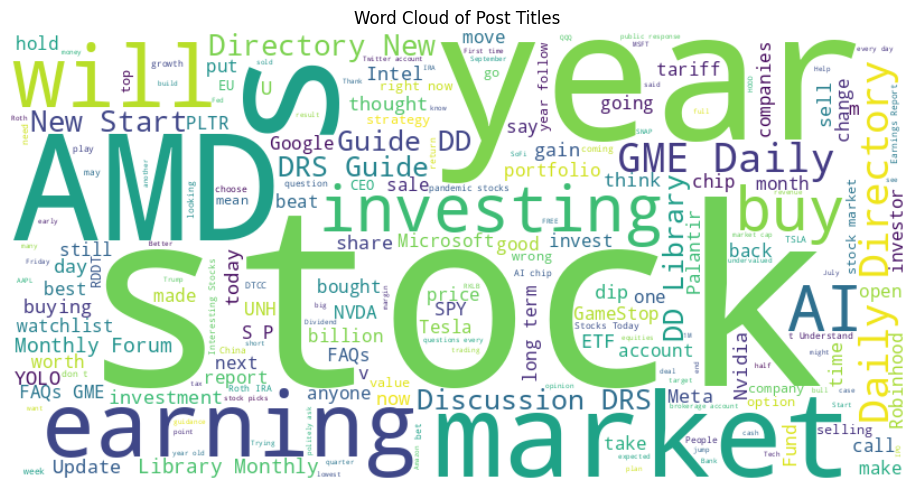

In [ ]:
text = ' '.join(merged['title'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Post Titles')
plt.tight_layout()
plt.show()

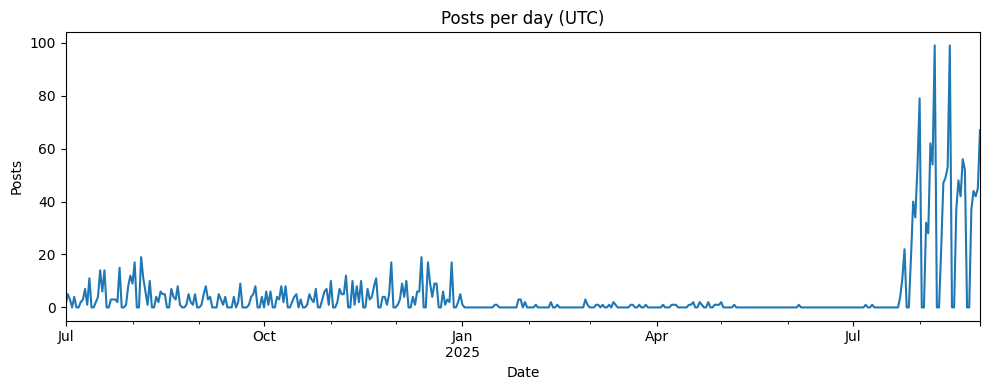

In [ ]:
merged['trade_date'] = pd.to_datetime(merged['trade_date'], utc=True)

daily = (merged.set_index('trade_date')
           .resample('D')
           .size()
           .rename('count'))

ax = daily.plot(figsize=(10,4), title='Posts per day (UTC)')
ax.set_xlabel('Date'); ax.set_ylabel('Posts')
plt.tight_layout(); plt.show()

In [ ]:
merged['hour'] = merged['date'].dt.hour

In [ ]:
merged['hour'].describe()

,hour
count,2026.000000
mean,13.424482
std,6.709380
min,0.000000
25%,9.000000
50%,15.000000
75%,19.000000
max,23.000000


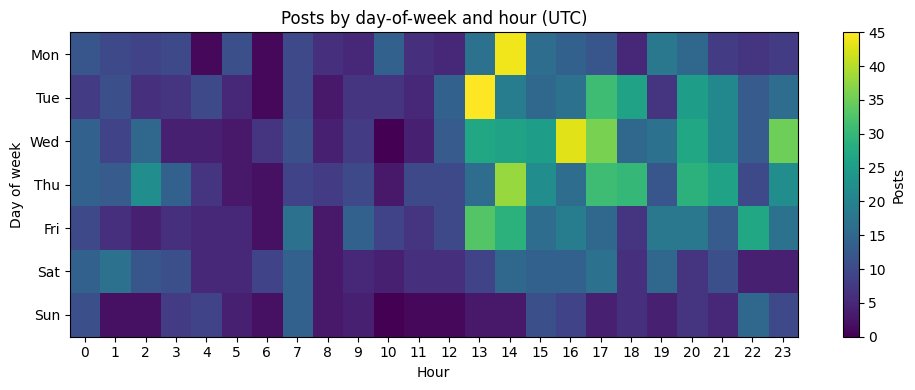

In [ ]:
import numpy as np

tmp = pd.DataFrame({
    'dow': merged['date'].dt.dayofweek,
    'hour': merged['date'].dt.hour
})
heat = tmp.value_counts().unstack(fill_value=0).reindex(index=range(7), columns=range(24), fill_value=0)

plt.figure(figsize=(10,4))
plt.imshow(heat, aspect='auto', interpolation='nearest')
plt.colorbar(label='Posts')
plt.yticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(range(24), range(24))
plt.title('Posts by day-of-week and hour (UTC)')
plt.xlabel('Hour'); plt.ylabel('Day of week')
plt.tight_layout(); plt.show()


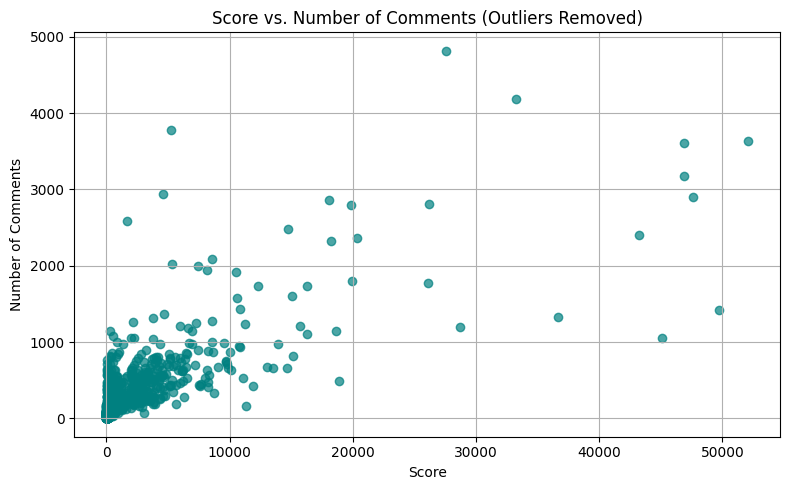

In [ ]:
import numpy as np

score_thresh = np.percentile(merged['score'], 95)
comments_thresh = np.percentile(merged['num_comments'], 95)

merged_filtered = df[
    (merged['score'] <= score_thresh) &
    (merged['num_comments'] <= comments_thresh)
]

plt.figure(figsize=(8, 5))
plt.scatter(merged_filtered['score'], merged_filtered['num_comments'], alpha=0.7, color='teal')
plt.title('Score vs. Number of Comments (Outliers Removed)')
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.tight_layout()
plt.show()


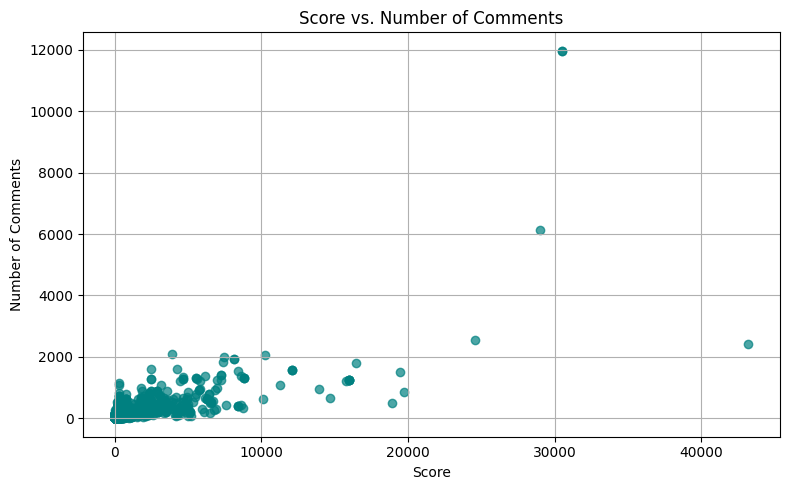

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(merged['score'], merged['num_comments'], alpha=0.7, color='teal')
plt.title('Score vs. Number of Comments')
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.tight_layout()
plt.show()

data exploration and cleaning

In [ ]:
long['date'].value_counts()

,count
date,
2025-08-29,126
2025-08-07,126
2025-08-13,126
2025-08-26,126
2025-08-28,126
...,...
2024-08-08,119
2024-08-09,119
2024-08-12,119


In [ ]:
long['adj_close'].nunique()

24899

In [ ]:
long.nunique()

,0
feature,
date,305
ticker,126
adj_close,24899
ret_1d,34016
cum_growth,33909
exret_vs_bench,34681


In [ ]:
print(merged.columns.tolist())

['id', 'title', 'selftext', 'score', 'num_comments', 'author', 'url', 'subreddit', 'source', 'clean_text', 'ticker', 'date', 'trade_date', 'adj_close', 'ret_1d', 'cum_growth', 'exret_vs_bench']


In [ ]:
merged = merged.loc[:, ~merged.columns.duplicated()]

In [ ]:
print(merged.columns.tolist())


['id', 'title', 'selftext', 'score', 'num_comments', 'author', 'url', 'subreddit', 'source', 'clean_text', 'ticker', 'date', 'trade_date', 'adj_close', 'ret_1d', 'cum_growth', 'exret_vs_bench']


check for missing values

In [ ]:
missing_ret = merged[merged["ret_1d"].isna()]
missing_ret.head()

,id,title,selftext,score,num_comments,author,url,subreddit,source,clean_text,ticker,date,trade_date,adj_close,ret_1d,cum_growth,exret_vs_bench
411,1ma8fm5,Figuring out the Figma IPO! (DD on $FIG),# I love IPOs.\n\nThe last IPO I thought was a...,268,216,WinningWatchlist,https://www.reddit.com/r/stocks/comments/1ma8f...,stocks,new,love ipos last ipo thought amazing coreweave p...,FIG,2025-07-27 00:13:47,2025-07-25,NaN,NaN,NaN,NaN
489,1mdzez8,Managing the “pop” of an IPO (FIG),Hi All\n\nThanks for taking the time.\n\nI am ...,0,6,Upset_Letter275,https://www.reddit.com/r/stocks/comments/1mdze...,stocks,new,hi thanks taking time investor moderate experi...,FIG,2025-07-31 11:49:55,2025-07-31,115.5,NaN,NaN,NaN
503,1me69dm,"$FIG is indicating $95-100, per CNBC","That values it at \~$59B, at $100/share, and ...",338,277,WinningWatchlist,https://www.reddit.com/r/stocks/comments/1me69...,stocks,new,values $59b $100share implies close $40b overv...,FIG,2025-07-31 16:29:46,2025-07-31,115.5,NaN,NaN,NaN
997,1mjer7s,Can't wait for WYFI IPO tomorrow!,"Can't wait for WYFI IPO, BTBT owns almost 80% ...",43,37,Drew_82,https://i.redd.it/vo6vkuzneghf1.png,wallstreetbets,new,cant wait wyfi ipo btbt owns almost 80 wyfi lo...,WYFI,2025-08-06 19:51:20,2025-08-06,NaN,NaN,NaN,NaN
999,1mjetmw,Bit Digital Inc. $BTBT & WhiteFiber IPO $WYFI ...,"WhiteFiber ($WYFI), an AI Infrastructure & Dat...",47,25,DonaldPump1,https://www.reddit.com/gallery/1mjetmw,wallstreetbets,new,whitefiber $wyfi ai infrastructure data center...,WYFI,2025-08-06 19:53:58,2025-08-06,NaN,NaN,NaN,NaN


In [ ]:
missing_ret["date"] = pd.to_datetime(missing_ret["date"])

/tmp/ipython-input-1594975499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ret["date"] = pd.to_datetime(missing_ret["date"])


In [ ]:
missing_ret['date'] = missing_ret['date'].dt.date
missing_ret['date'].value_counts()

/tmp/ipython-input-3867651386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ret['date'] = missing_ret['date'].dt.date


,count
date,
2025-07-31,2
2025-08-06,2
2025-07-30,2
2025-07-27,1
2024-07-01,1
2025-07-29,1


In [ ]:
missing_ret['date'].describe()

,date
count,9
unique,6
top,2025-07-31
freq,2


comparing df_combined_df vs the new merged df

In [ ]:
df_combined_df.columns

Index(['id', 'title', 'selftext', 'score', 'num_comments', 'created', 'author',
       'url', 'subreddit', 'source', 'clean_text', 'all_tickers'],
      dtype='object')

In [ ]:
merged.columns

Index(['id', 'title', 'selftext', 'score', 'num_comments', 'author', 'url',
       'subreddit', 'source', 'clean_text', 'ticker', 'date', 'trade_date',
       'adj_close', 'ret_1d', 'cum_growth', 'exret_vs_bench'],
      dtype='object')

In [ ]:
df_combined_df.shape

(6496, 12)

In [ ]:
merged.shape

(2017, 17)

In [ ]:
# range of df_wsb
print(merged['date'].min())
print(merged['date'].max())

2024-07-01 11:22:37
2025-08-30 09:21:20


In [ ]:
merged.head(3)

,id,title,selftext,score,num_comments,author,url,subreddit,source,clean_text,ticker,date,trade_date,adj_close,ret_1d,cum_growth,exret_vs_bench
0,1du9km4,Cathie Wood's Ark Invest Sells Tesla Shares Wo...,Why Cathie Wood sold TSLA's shares at around $...,292,164,OG_Time_To_Kill,https://www.reddit.com/r/stocks/comments/1du9k...,stocks,top_year,cathie wood sold tslas shares around $230 givi...,BULL,2024-07-03 08:44:49,2024-07-03,11.140000,-0.000897,1.001799,-0.005359
1,1du9km4,Cathie Wood's Ark Invest Sells Tesla Shares Wo...,Why Cathie Wood sold TSLA's shares at around $...,292,164,OG_Time_To_Kill,https://www.reddit.com/r/stocks/comments/1du9k...,stocks,top_year,cathie wood sold tslas shares around $230 givi...,TSLA,2024-07-03 08:44:49,2024-07-03,246.389999,0.065424,1.174068,0.060962
2,1dvxwo2,These are the stocks on my watchlist (7/5),These are the stocks on my watchlist (7/5)\n\n...,125,83,WinningWatchlist,https://www.reddit.com/r/stocks/comments/1dvxw...,stocks,top_year,stocks watchlist 75 hi exprop trader trades eq...,OPEN,2024-07-05 13:23:38,2024-07-05,1.760000,-0.022222,0.983240,-0.027989


Word Cloud

In [ ]:
merged.columns

Index(['id', 'title', 'selftext', 'score', 'num_comments', 'author', 'url',
       'subreddit', 'source', 'clean_text', 'ticker', 'date', 'trade_date',
       'adj_close', 'ret_1d', 'cum_growth', 'exret_vs_bench'],
      dtype='object')

In [ ]:
keep = ["id","ticker","date","trade_date","clean_text",
        "score","num_comments","ret_1d","exret_vs_bench","adj_close","subreddit"]
final_df = merged[keep].copy()

In [ ]:
print(final_df.shape)

(2017, 11)


sentiment analysis

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply sentiment
final_df["sentiment_score"] = final_df["clean_text"].apply(
    lambda x: analyzer.polarity_scores(str(x))["compound"]
)

In [ ]:
final_df.head(5)

,id,ticker,date,trade_date,clean_text,score,num_comments,ret_1d,exret_vs_bench,adj_close,subreddit,sentiment_score
0,1du9km4,BULL,2024-07-03 08:44:49,2024-07-03,cathie wood sold tslas shares around $230 givi...,292,164,-0.000897,-0.005359,11.140000,stocks,0.9922
1,1du9km4,TSLA,2024-07-03 08:44:49,2024-07-03,cathie wood sold tslas shares around $230 givi...,292,164,0.065424,0.060962,246.389999,stocks,0.9922
2,1dvxwo2,OPEN,2024-07-05 13:23:38,2024-07-05,stocks watchlist 75 hi exprop trader trades eq...,125,83,-0.022222,-0.027989,1.760000,stocks,-0.7717
3,1dvxwo2,TSLA,2024-07-05 13:23:38,2024-07-05,stocks watchlist 75 hi exprop trader trades eq...,125,83,0.020821,0.015054,251.520004,stocks,-0.7717
4,1dvxwo2,AMZN,2024-07-05 13:23:38,2024-07-05,stocks watchlist 75 hi exprop trader trades eq...,125,83,0.012197,0.006431,200.000000,stocks,-0.7717


In [ ]:
print(final_df.shape)

(2017, 12)


In [ ]:
daily_sentiment = (
    final_df.groupby(["ticker", "date"])["sentiment_score"]
      .mean()
      .reset_index()
)

In [ ]:
daily_sentiment.head(5)

,ticker,date,sentiment_score
0,AAPL,2024-07-10 13:02:23,0.4767
1,AAPL,2024-07-17 14:55:47,0.9042
2,AAPL,2024-08-05 14:47:30,0.2732
3,AAPL,2024-08-19 11:09:41,0.9451
4,AAPL,2024-09-10 12:47:24,0.5859


In [ ]:
vader_sentiment = pd.merge(
    daily_sentiment,
    final_df[["ticker","date","ret_1d","exret_vs_bench"]].drop_duplicates(),
    on=["ticker","date"],
    how="inner"
)

In [ ]:
vader_sentiment.head(5)

,ticker,date,sentiment_score,ret_1d,exret_vs_bench
0,AAPL,2024-07-10 13:02:23,0.4767,0.018804,0.008908
1,AAPL,2024-07-17 14:55:47,0.9042,-0.025296,-0.011275
2,AAPL,2024-08-05 14:47:30,0.2732,-0.048167,-0.019043
3,AAPL,2024-08-19 11:09:41,0.9451,-0.000708,-0.010269
4,AAPL,2024-09-10 12:47:24,0.5859,-0.003621,-0.007977


In [ ]:
vader_sentiment.groupby("ticker")[["sentiment_score","ret_1d"]].corr()

sentiment_score    ret_1d
ticker                                           
AAPL   sentiment_score         1.000000  0.075896
       ret_1d                  0.075896  1.000000
ABAT   sentiment_score              NaN       NaN
       ret_1d                       NaN       NaN
ACHR   sentiment_score         1.000000 -0.322095
...                                 ...       ...
WYFI   ret_1d                       NaN       NaN
XLE    sentiment_score         1.000000 -0.633583
       ret_1d                 -0.633583  1.000000
XOM    sentiment_score         1.000000  0.139877
       ret_1d                  0.139877  1.000000

[158 rows x 2 columns]

In [ ]:
vader_sentiment["next_day_return"] = vader_sentiment.groupby("ticker")["ret_1d"].shift(-1)

In [ ]:
vader_sentiment.head(5)

,ticker,date,sentiment_score,ret_1d,exret_vs_bench,next_day_return
0,AAPL,2024-07-10 13:02:23,0.4767,0.018804,0.008908,-0.025296
1,AAPL,2024-07-17 14:55:47,0.9042,-0.025296,-0.011275,-0.048167
2,AAPL,2024-08-05 14:47:30,0.2732,-0.048167,-0.019043,-0.000708
3,AAPL,2024-08-19 11:09:41,0.9451,-0.000708,-0.010269,-0.003621
4,AAPL,2024-09-10 12:47:24,0.5859,-0.003621,-0.007977,0.002173


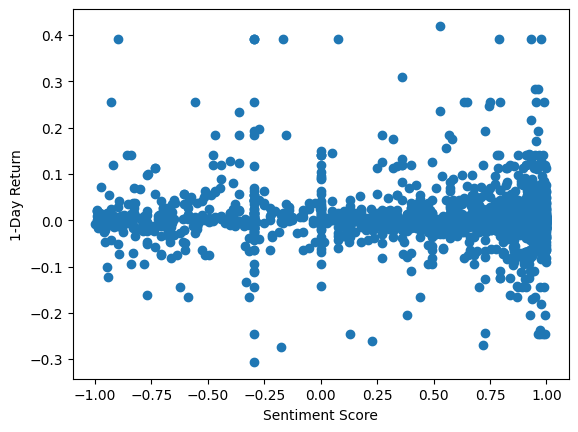

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(vader_sentiment["sentiment_score"], vader_sentiment["ret_1d"])
plt.xlabel("Sentiment Score")
plt.ylabel("1-Day Return")
plt.show()

In [ ]:
corr = final_df["sentiment_score"].corr(final_df["ret_1d"])
print("Correlation:", corr)

Correlation: -0.025782830595378343


<Axes: xlabel='sentiment_score', ylabel='ret_1d'>

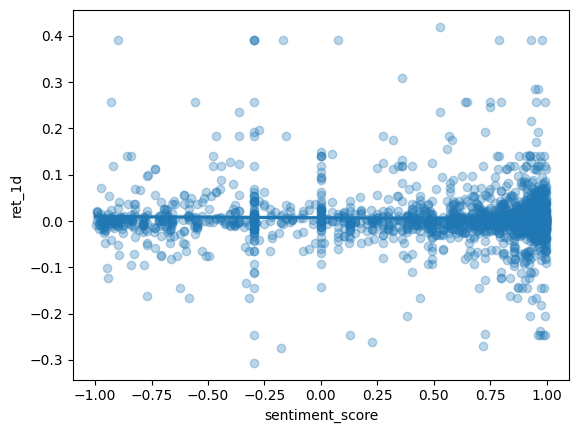

In [ ]:
import seaborn as sns

sns.regplot(
    x=final_df["sentiment_score"],
    y=final_df["ret_1d"],
    scatter_kws={"alpha":0.3}
)

In [ ]:
import numpy as np

final_df["sentiment_bucket"] = np.where(final_df["sentiment_score"] > 0.2, "Positive",
                              np.where(final_df["sentiment_score"] < -0.2, "Negative", "Neutral"))

avg_returns = final_df.groupby("sentiment_bucket")["ret_1d"].mean()
print(avg_returns)

sentiment_bucket
Negative    0.008728
Neutral     0.009453
Positive    0.004803
Name: ret_1d, dtype: float64


In [ ]:
final_df["ret_next_day"] = final_df.groupby("ticker")["ret_1d"].shift(-1)
corr_next = final_df["sentiment_score"].corr(final_df["ret_next_day"])
print("Correlation with next-day returns:", corr_next)

Correlation with next-day returns: 0.0017359103493880187


In [ ]:
final_df["sentiment_q"] = pd.qcut(final_df["sentiment_score"], q=5, labels=False)
final_df.groupby("sentiment_q")["ret_next_day"].mean()

,ret_next_day
sentiment_q,
0,0.007078
1,0.003198
2,0.007433
3,0.007393
4,0.005286


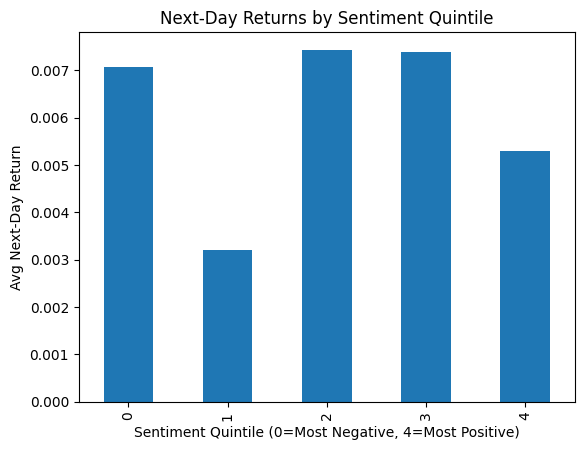

In [ ]:
import matplotlib.pyplot as plt

avg_returns_by_q = final_df.groupby("sentiment_q")["ret_next_day"].mean()
avg_returns_by_q.plot(kind="bar", title="Next-Day Returns by Sentiment Quintile")
plt.xlabel("Sentiment Quintile (0=Most Negative, 4=Most Positive)")
plt.ylabel("Avg Next-Day Return")
plt.show()

In [ ]:
#final_df.head(5)

,id,ticker,date,trade_date,clean_text,score,num_comments,ret_1d,exret_vs_bench,adj_close,subreddit,sentiment_score,sentiment_bucket,ret_next_day,sentiment_q
0,1du9km4,BULL,2024-07-03 08:44:49,2024-07-03,cathie wood sold tslas shares around $230 givi...,292,164,-0.000897,-0.005359,11.140000,stocks,0.9922,Positive,-0.000448,4
1,1du9km4,TSLA,2024-07-03 08:44:49,2024-07-03,cathie wood sold tslas shares around $230 givi...,292,164,0.065424,0.060962,246.389999,stocks,0.9922,Positive,0.020821,4
2,1dvxwo2,OPEN,2024-07-05 13:23:38,2024-07-05,stocks watchlist 75 hi exprop trader trades eq...,125,83,-0.022222,-0.027989,1.760000,stocks,-0.7717,Negative,0.028409,0
3,1dvxwo2,TSLA,2024-07-05 13:23:38,2024-07-05,stocks watchlist 75 hi exprop trader trades eq...,125,83,0.020821,0.015054,251.520004,stocks,-0.7717,Negative,0.003545,0
4,1dvxwo2,AMZN,2024-07-05 13:23:38,2024-07-05,stocks watchlist 75 hi exprop trader trades eq...,125,83,0.012197,0.006431,200.000000,stocks,-0.7717,Negative,0.002257,0


In [ ]:
# If in Colab/Jupyter
!pip install -q transformers torch --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

In [ ]:
MODEL_NAME = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

device = 0 if torch.cuda.is_available() else -1  # GPU if available
clf = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-classification",
    device=device,
    truncation=True,
    max_length=512,
    return_all_scores=True   # <-- we’ll get prob. for all labels
)

# FinBERT labels come back as strings like 'positive','neutral','negative'

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
if "clean_text" in final_df.columns:
    text_series = final_df["clean_text"].fillna("").astype(str)
else:
    text_series = (final_df["title"].fillna("") + " " + final_df["selftext"].fillna("")).astype(str)

In [ ]:
def finbert_scores(texts, batch_size=64):
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist()
        preds = clf(batch)  # list of [ {label:..., score:...}, ... ] per row
        for p in preds:
            # Map labels to probabilities
            pm = {d["label"].lower(): d["score"] for d in p}
            pos = pm.get("positive", 0.0)
            neg = pm.get("negative", 0.0)
            neu = pm.get("neutral",  0.0)
            signed = pos - neg
            label = max(pm, key=pm.get)
            out.append((signed, pos, neg, neu, label))
    cols = ["finbert_signed", "finbert_pos", "finbert_neg", "finbert_neu", "finbert_label"]
    return pd.DataFrame(out, columns=cols)

fin_df = finbert_scores(text_series, batch_size=64)
finbert_df = pd.concat([final_df.reset_index(drop=True), fin_df], axis=1)
finbert_df.head(3)

KeyboardInterrupt: 

In [ ]:
daily_sent = (finbert_df
    .groupby(["ticker","date"], as_index=False)
    .agg(
        finbert_signed_mean=("finbert_signed","mean"),
        finbert_pos_mean   =("finbert_pos","mean"),
        finbert_neg_mean   =("finbert_neg","mean"),
        posts=("id","count")
    )
)

In [ ]:
price_cols = ["ticker","date","ret_1d","exret_vs_bench"]
prices = finbert_df[price_cols].drop_duplicates()

finbert_df_final = daily_sent.merge(prices, on=["ticker","date"], how="inner")
finbert_df_final = finbert_df_final.sort_values(["ticker","date"])
finbert_df_final["ret_next_day"] = finbert_df_final.groupby("ticker")["ret_1d"].shift(-1)
finbert_df_final.head(3)


In [ ]:
corr = finbert_df_final["finbert_signed_mean"].corr(finbert_df_final["ret_next_day"])
print("FinBERT signed vs next-day return (corr):", corr)

# using FinBERT-tone with extreme sentiment only

In [ ]:
# FinBERT-tone with Event Study Filtering (Extreme Sentiment Only)

MODEL_NAME = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

device = 0 if torch.cuda.is_available() else -1
clf = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-classification",
    device=device,
    truncation=True,
    max_length=512,
    top_k=None
)

if "clean_text" in final_df.columns:
    text_series = final_df["clean_text"].fillna("").astype(str)
else:
    text_series = (final_df["title"].fillna("") + " " + final_df["selftext"].fillna("")).astype(str)

def finbert_tone_scores(texts, batch_size=64):
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist()
        preds = clf(batch)
        for p in preds:
            pm = {d["label"].lower(): d["score"] for d in p}
            pos = pm.get("positive", 0.0)
            neg = pm.get("negative", 0.0)
            neu = pm.get("neutral", 0.0)
            signed = pos - neg
            label = max(pm, key=pm.get)
            out.append((signed, pos, neg, neu, label))
    return pd.DataFrame(out, columns=["signed", "pos", "neg", "neu", "label"])

finbert_tone_df = finbert_tone_scores(text_series)
finbert_tone_df = pd.concat([final_df.reset_index(drop=True), finbert_tone_df], axis=1)

daily_sent = (finbert_tone_df
    .groupby(["ticker","date"], as_index=False)
    .agg(
        signed_mean=("signed","mean"),
        pos_mean=("pos","mean"),
        neg_mean=("neg","mean"),
        posts=("id","count")
    )
)

price_cols = ["ticker","date","ret_1d"]
prices = finbert_tone_df[price_cols].drop_duplicates()
df_final = daily_sent.merge(prices, on=["ticker","date"], how="inner")
df_final = df_final.sort_values(["ticker","date"])
df_final["ret_next_day"] = df_final.groupby("ticker")["ret_1d"].shift(-1)

q_low = df_final["signed_mean"].quantile(0.10)
q_high = df_final["signed_mean"].quantile(0.90)
df_extreme = df_final[(df_final["signed_mean"] <= q_low) | (df_final["signed_mean"] >= q_high)]

corr_extreme = df_extreme["signed_mean"].corr(df_extreme["ret_next_day"])
print(f"Correlation (extreme sentiment days only): {corr_extreme:.4f}")

print("\nExtreme sentiment sample:\n", df_extreme.head())

# Classification Analysis (attempting to predict next-day up/down from sentiment)

Numeric features: ['score', 'num_comments', 'ret_1d', 'exret_vs_bench', 'adj_close', 'sentiment_score', 'sentiment_q']
Categorical features: ['ticker', 'subreddit', 'sentiment_bucket']
Accuracy: 0.5348837209302325
ROC AUC: 0.5615228100235597

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.54      0.52       184
           1       0.56      0.53      0.55       203

    accuracy                           0.53       387
   macro avg       0.53      0.54      0.53       387
weighted avg       0.54      0.53      0.54       387


Confusion Matrix:
 [[ 99  85]
 [ 95 108]]


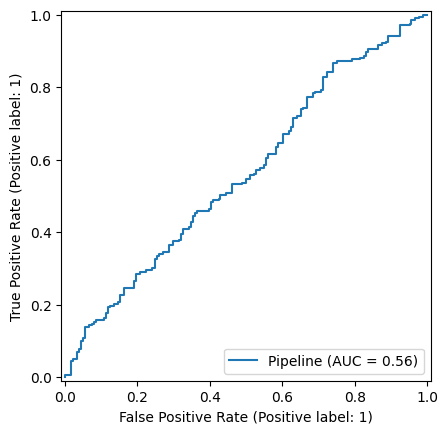

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

classification_df = final_df.copy()

# Drop rows missing target
classification_df = classification_df.dropna(subset=["ret_next_day", "sentiment_score"])

# Target: 1 if next-day return > 0 else 0
classification_df["target"] = (classification_df["ret_next_day"] > 0).astype(int)

# Define features
drop_cols = ["id", "date", "trade_date", "clean_text", "ret_next_day"]  # drop non-useful
X = classification_df.drop(columns=drop_cols + ["target"])
y = classification_df["target"]

# Identify numeric & categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


# Preprocessor with imputation
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Logistic regression pipeline
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit model
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best hyperparameters found: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Accuracy: 0.6396396396396397
ROC AUC: 0.674065334414866

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.49      0.53       142
           1       0.66      0.75      0.71       191

    accuracy                           0.64       333
   macro avg       0.63      0.62      0.62       333
weighted avg       0.63      0.64      0.63       333


Confusion Matrix:
 [[ 69  73]
 [ 47 144]]


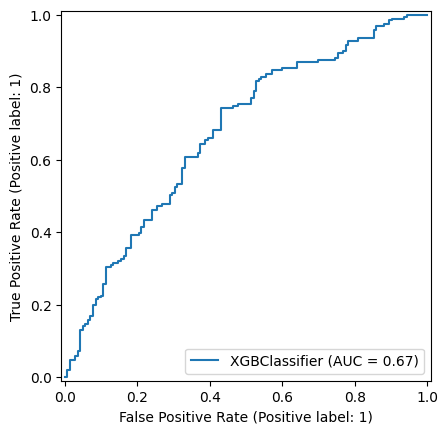


Feature importance:
                       feature  importance
1                 sentiment_q    0.106966
9         rolling_sent_mean_3    0.080129
10         rolling_sent_std_3    0.074748
4                      ret_1d    0.074316
3                num_comments    0.072438
0             sentiment_score    0.071151
11         rolling_ret_mean_3    0.070833
2                       score    0.070263
6                 ret_1d_lag1    0.069876
12          rolling_ret_std_3    0.069182
5              exret_vs_bench    0.068420
8                 ret_1d_lag3    0.065127
7                 ret_1d_lag2    0.060889
13   sentiment_bucket_Neutral    0.045663
14  sentiment_bucket_Positive    0.000000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Creating 5-day cumulative forward return as target
classification_df["ret_5d_cum"] = sum([classification_df["ret_next_day"].shift(-i) for i in range(1, 6)])

# Dropping rows with missing target
classification_df = classification_df.dropna(subset=["ret_5d_cum"])

# Creating binary target
classification_df["target"] = (classification_df["ret_5d_cum"] > 0).astype(int)

# Engineering lagged returns
classification_df["ret_1d_lag1"] = classification_df["ret_1d"].shift(1)
classification_df["ret_1d_lag2"] = classification_df["ret_1d"].shift(2)
classification_df["ret_1d_lag3"] = classification_df["ret_1d"].shift(3)

# Rolling averages and std
classification_df["rolling_sent_mean_3"] = classification_df["sentiment_score"].rolling(3, min_periods=1).mean()
classification_df["rolling_sent_std_3"] = classification_df["sentiment_score"].rolling(3, min_periods=1).std()
classification_df["rolling_ret_mean_3"] = classification_df["ret_1d"].rolling(3, min_periods=1).mean()
classification_df["rolling_ret_std_3"] = classification_df["ret_1d"].rolling(3, min_periods=1).std()

# One-hot encoding sentiment bucket
classification_df = pd.get_dummies(classification_df, columns=["sentiment_bucket"], drop_first=True)

# Selecting features
features = [
    "sentiment_score", "sentiment_q", "score", "num_comments",
    "ret_1d", "exret_vs_bench",
    "ret_1d_lag1", "ret_1d_lag2", "ret_1d_lag3",
    "rolling_sent_mean_3", "rolling_sent_std_3",
    "rolling_ret_mean_3", "rolling_ret_std_3"
] + [col for col in classification_df.columns if col.startswith("sentiment_bucket_")]

classification_df = classification_df.dropna(subset=features)

X = classification_df[features]
y = classification_df["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Base XGBoost model
xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42)

# Hyperparameter grid
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 3, 5]
}

# Running RandomizedSearchCV
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)

print("Best hyperparameters found:", search.best_params_)

# Creating final model using best params
final_model = XGBClassifier(
    **search.best_params_,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

# Fitting final model
final_model.fit(X_train, y_train)

# Making predictions
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# Evaluating model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test)
plt.show()

# Feature importance
importances = pd.DataFrame({
    "feature": features,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)
print("\nFeature importance:\n", importances)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 763, number of negative: 567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1330, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573684 -> initscore=0.296899
[LightGBM] [Info] Start training from score 0.296899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

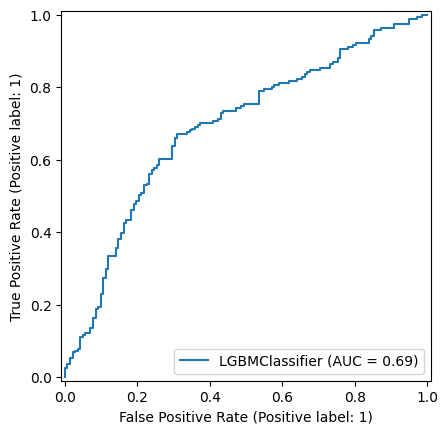


Feature importance:
                       feature  importance
0             sentiment_score         308
3                num_comments         281
10         rolling_sent_std_3         240
8                 ret_1d_lag3         237
9         rolling_sent_mean_3         230
2                       score         220
7                 ret_1d_lag2         211
4                      ret_1d         204
6                 ret_1d_lag1         194
12          rolling_ret_std_3         177
11         rolling_ret_mean_3         174
5              exret_vs_bench         106
1                 sentiment_q          10
14  sentiment_bucket_Positive           3
13   sentiment_bucket_Neutral           0


In [ ]:
# Predicting 5-Day Forward Returns with LightGBM + Feature Engineering + Hyperparameter Tuning

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import lightgbm as lgb

# Creating 5-day cumulative forward return
classification_df["ret_5d_cum"] = sum(
    [classification_df["ret_next_day"].shift(-i) for i in range(1, 6)]
)

# Dropping rows with missing labels
classification_df = classification_df.dropna(subset=["ret_5d_cum"])

# Creating binary target
classification_df["target"] = (classification_df["ret_5d_cum"] > 0).astype(int)

# Creating lagged returns
classification_df["ret_1d_lag1"] = classification_df["ret_1d"].shift(1)
classification_df["ret_1d_lag2"] = classification_df["ret_1d"].shift(2)
classification_df["ret_1d_lag3"] = classification_df["ret_1d"].shift(3)

# Creating rolling statistics
classification_df["rolling_sent_mean_3"] = classification_df["sentiment_score"].rolling(3, min_periods=1).mean()
classification_df["rolling_sent_std_3"] = classification_df["sentiment_score"].rolling(3, min_periods=1).std()
classification_df["rolling_ret_mean_3"] = classification_df["ret_1d"].rolling(3, min_periods=1).mean()
classification_df["rolling_ret_std_3"] = classification_df["ret_1d"].rolling(3, min_periods=1).std()

# One-hot encoding sentiment bucket
classification_df = pd.get_dummies(classification_df, columns=["sentiment_bucket"], drop_first=True)

# Defining features
features = [
    "sentiment_score", "sentiment_q", "score", "num_comments",
    "ret_1d", "exret_vs_bench",
    "ret_1d_lag1", "ret_1d_lag2", "ret_1d_lag3",
    "rolling_sent_mean_3", "rolling_sent_std_3",
    "rolling_ret_mean_3", "rolling_ret_std_3"
] + [col for col in classification_df.columns if col.startswith("sentiment_bucket_")]

# Dropping rows with missing features
classification_df = classification_df.dropna(subset=features)

# Creating feature matrix and target vector
X = classification_df[features]
y = classification_df["target"]

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y
)

# Initializing LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Defining hyperparameter grid for tuning
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [15, 31, 63],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_samples": [1, 3, 5],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0, 0.1, 0.5]
}

# Performing randomized search cross-validation
search = RandomizedSearchCV(
    lgb_clf,
    param_distributions=param_dist,
    n_iter=25,            # Trying 25 random combinations
    scoring="roc_auc",    # Optimizing AUC
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search
search.fit(X_train, y_train)

# Retrieving best model
best_model = search.best_estimator_
print("Best hyperparameters found:", search.best_params_)

# Predicting on test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluating model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plotting ROC curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

# Computing feature importance
importances = pd.DataFrame({
    "feature": features,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)
print("\nFeature importance:\n", importances)